In [261]:
# Prerequisites
# ! pip install -U pandas
# ! pip install -U nltk  
# ! pip install -U gensim     
# ! pip install -U wordcloud
# ! python3 -m spacy download en_core_web_sm

In [262]:
# Importing Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

In [263]:
# Loading Dataset
df=pd.read_csv('RAW_NEWS.csv')
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...


# PRE-PROCESSING DATA

In [264]:
# Cleansing the News heading by removing un-nessary words
df['HeadingOfNews'] = df['HeadingOfNews'].str.replace('\+|- DAWN.COM| Newspaper', '')

# Removing "Published in Dawn" from the end off news content
df['BodyOfNews'] = df['BodyOfNews'].str.split('Published in Dawn,').str[0]

/var/folders/mc/90y0gmt947b4b4xcf3kflwqc0000gn/T/ipykernel_4884/3440229990.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [265]:
df['originalCombined'] = df['HeadingOfNews'] + ' ' + df['BodyOfNews']
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...


In [266]:
df['originalCombined'][0]

'Qaiser rues decision to grant extension to Bajwa -  ISLAMABAD: A week after retired Gen Qamar Javed Bajwa completed his extended tenure, Pakistan Tehreek-i-Insaf (PTI) leader Asad Qaiser has said the decision to grant a three-year extension to the former army chief was a “wrong decision”, which the party regretted.\nGen Bajwa was given an extension by former prime minister Imran Khan in 2019 three months before the completion of his three-year term as the chief of army staff. Mr Qaiser, however, added that the decision to extend his tenure was a “collective” decision of parliament and all political parties supported the move. \n“Everyone [in the party ranks] is realising that it was a mistake to grant him [Bajwa] an extension,” the former National Assembly speaker said, adding that such decisions should not be made for the sake of individuals.\nThe remarks by the former National Assembly spea\xad\xadker came during an interview with DawnNewsTV’s Nadir Gurmani on Saturday. \nWhen asked

In [267]:
# download stopwords
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aniqurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [268]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['originalCombined']))

print(data_words[:1])

[['qaiser', 'rues', 'decision', 'to', 'grant', 'extension', 'to', 'bajwa', 'islamabad', 'week', 'after', 'retired', 'gen', 'qamar', 'javed', 'bajwa', 'completed', 'his', 'extended', 'tenure', 'pakistan', 'tehreek', 'insaf', 'pti', 'leader', 'asad', 'qaiser', 'has', 'said', 'the', 'decision', 'to', 'grant', 'three', 'year', 'extension', 'to', 'the', 'former', 'army', 'chief', 'was', 'wrong', 'decision', 'which', 'the', 'party', 'regretted', 'gen', 'bajwa', 'was', 'given', 'an', 'extension', 'by', 'former', 'prime', 'minister', 'imran', 'khan', 'in', 'three', 'months', 'before', 'the', 'completion', 'of', 'his', 'three', 'year', 'term', 'as', 'the', 'chief', 'of', 'army', 'staff', 'mr', 'qaiser', 'however', 'added', 'that', 'the', 'decision', 'to', 'extend', 'his', 'tenure', 'was', 'collective', 'decision', 'of', 'parliament', 'and', 'all', 'political', 'parties', 'supported', 'the', 'move', 'everyone', 'in', 'the', 'party', 'ranks', 'is', 'realising', 'that', 'it', 'was', 'mistake', 'to

In [269]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['qaiser', 'rues', 'decision', 'to', 'grant', 'extension', 'to', 'bajwa', 'islamabad', 'week', 'after', 'retired', 'gen_qamar_javed_bajwa', 'completed', 'his', 'extended', 'tenure', 'pakistan_tehreek_insaf', 'pti', 'leader', 'asad_qaiser', 'has', 'said', 'the', 'decision', 'to', 'grant', 'three', 'year', 'extension', 'to', 'the', 'former', 'army_chief', 'was', 'wrong', 'decision', 'which', 'the', 'party', 'regretted', 'gen_bajwa', 'was', 'given', 'an', 'extension', 'by', 'former', 'prime_minister_imran_khan', 'in', 'three', 'months', 'before', 'the', 'completion', 'of', 'his', 'three', 'year', 'term', 'as', 'the', 'chief', 'of', 'army_staff', 'mr', 'qaiser', 'however', 'added', 'that', 'the', 'decision', 'to', 'extend', 'his', 'tenure', 'was', 'collective', 'decision', 'of', 'parliament', 'and', 'all', 'political_parties', 'supported', 'the', 'move', 'everyone', 'in', 'the', 'party', 'ranks', 'is', 'realising', 'that', 'it', 'was', 'mistake', 'to', 'grant', 'him', 'bajwa', 'an', 'exten

In [270]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [271]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['rue', 'decision', 'grant', 'extension', 'bajwa', 'week', 'complete', 'extended', 'tenure', 'leader', 'asad_qais', 'say', 'decision', 'grant', 'year', 'extension', 'former', 'wrong', 'decision', 'party', 'regret', 'gen_bajwa', 'give', 'extension', 'former', 'prime_minister', 'month', 'completion', 'year', 'term', 'chief', 'however', 'add', 'decision', 'extend', 'tenure', 'collective', 'decision', 'parliament', 'political_partie', 'support', 'move', 'party', 'rank', 'realise', 'mistake', 'bajwa', 'former', 'national_assembly', 'speaker', 'say', 'add', 'decision', 'make', 'sake', 'individual', 'remark', 'former', 'national_assembly', 'come', 'interview', 'ask', 'pressure', 'government', 'extend', 'tenure', 'refuse', 'answer', 'question', 'say', 'matter', 'decision', 'take', 'move', 'grant', 'extension', 'former', 'army_chief', 'wrong', 'nonetheless', 'open', 'talk', 'leader', 'say', 'former', 'rule', 'party', 'willing', 'sit', 'government', 'find', 'solution', 'prevail', 'political', '

In [272]:
def preprocess(text):
    # Remove Stop Words
    data_words_nostops = remove_stopwords(text)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    # nlp = spacy.load("en_core_web_lg")

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    return data_lemmatized

In [273]:
data_lemmatized = preprocess(data_words)
print(data_lemmatized[:1])
df['clean'] = data_lemmatized

[['rue', 'decision', 'grant', 'extension', 'bajwa', 'week', 'complete', 'extended', 'tenure', 'leader', 'asad_qais', 'say', 'decision', 'grant', 'year', 'extension', 'former', 'wrong', 'decision', 'party', 'regret', 'gen_bajwa', 'give', 'extension', 'former', 'prime_minister', 'month', 'completion', 'year', 'term', 'chief', 'however', 'add', 'decision', 'extend', 'tenure', 'collective', 'decision', 'parliament', 'political_partie', 'support', 'move', 'party', 'rank', 'realise', 'mistake', 'bajwa', 'former', 'national_assembly', 'speaker', 'say', 'add', 'decision', 'make', 'sake', 'individual', 'remark', 'former', 'national_assembly', 'come', 'interview', 'ask', 'pressure', 'government', 'extend', 'tenure', 'refuse', 'answer', 'question', 'say', 'matter', 'decision', 'take', 'move', 'grant', 'extension', 'former', 'army_chief', 'wrong', 'nonetheless', 'open', 'talk', 'leader', 'say', 'former', 'rule', 'party', 'willing', 'sit', 'government', 'find', 'solution', 'prevail', 'political', '

In [274]:
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[rue, decision, grant, extension, bajwa, week,..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[opted, suicide_attack, treat, book, case, pos..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[police, official, martyr, nowshera, gun, poli..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal_miner, kill, gas, explosion, least, coal..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throw, joint, petition, perk, teacher, re..."


In [275]:
# Show original news
df['originalCombined'][0]

'Qaiser rues decision to grant extension to Bajwa -  ISLAMABAD: A week after retired Gen Qamar Javed Bajwa completed his extended tenure, Pakistan Tehreek-i-Insaf (PTI) leader Asad Qaiser has said the decision to grant a three-year extension to the former army chief was a “wrong decision”, which the party regretted.\nGen Bajwa was given an extension by former prime minister Imran Khan in 2019 three months before the completion of his three-year term as the chief of army staff. Mr Qaiser, however, added that the decision to extend his tenure was a “collective” decision of parliament and all political parties supported the move. \n“Everyone [in the party ranks] is realising that it was a mistake to grant him [Bajwa] an extension,” the former National Assembly speaker said, adding that such decisions should not be made for the sake of individuals.\nThe remarks by the former National Assembly spea\xad\xadker came during an interview with DawnNewsTV’s Nadir Gurmani on Saturday. \nWhen asked

In [276]:
# Show cleaned up news after removing stopwords
print(df['clean'][0])

['rue', 'decision', 'grant', 'extension', 'bajwa', 'week', 'complete', 'extended', 'tenure', 'leader', 'asad_qais', 'say', 'decision', 'grant', 'year', 'extension', 'former', 'wrong', 'decision', 'party', 'regret', 'gen_bajwa', 'give', 'extension', 'former', 'prime_minister', 'month', 'completion', 'year', 'term', 'chief', 'however', 'add', 'decision', 'extend', 'tenure', 'collective', 'decision', 'parliament', 'political_partie', 'support', 'move', 'party', 'rank', 'realise', 'mistake', 'bajwa', 'former', 'national_assembly', 'speaker', 'say', 'add', 'decision', 'make', 'sake', 'individual', 'remark', 'former', 'national_assembly', 'come', 'interview', 'ask', 'pressure', 'government', 'extend', 'tenure', 'refuse', 'answer', 'question', 'say', 'matter', 'decision', 'take', 'move', 'grant', 'extension', 'former', 'army_chief', 'wrong', 'nonetheless', 'open', 'talk', 'leader', 'say', 'former', 'rule', 'party', 'willing', 'sit', 'government', 'find', 'solution', 'prevail', 'political', 'i

# VISUALIZE CLEANED UP DATASET

In [277]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [278]:
# list_of_words
len(list_of_words)

464873

In [279]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

19695

In [280]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

<AxesSubplot: xlabel='count', ylabel='Topic'>

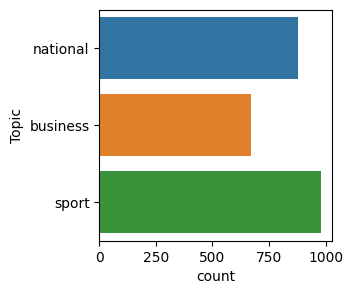

In [281]:
# plot the number of samples in 'HeadingOfNews'
plt.figure(figsize = (3, 3))
sns.countplot(y = "Topic", data = df)

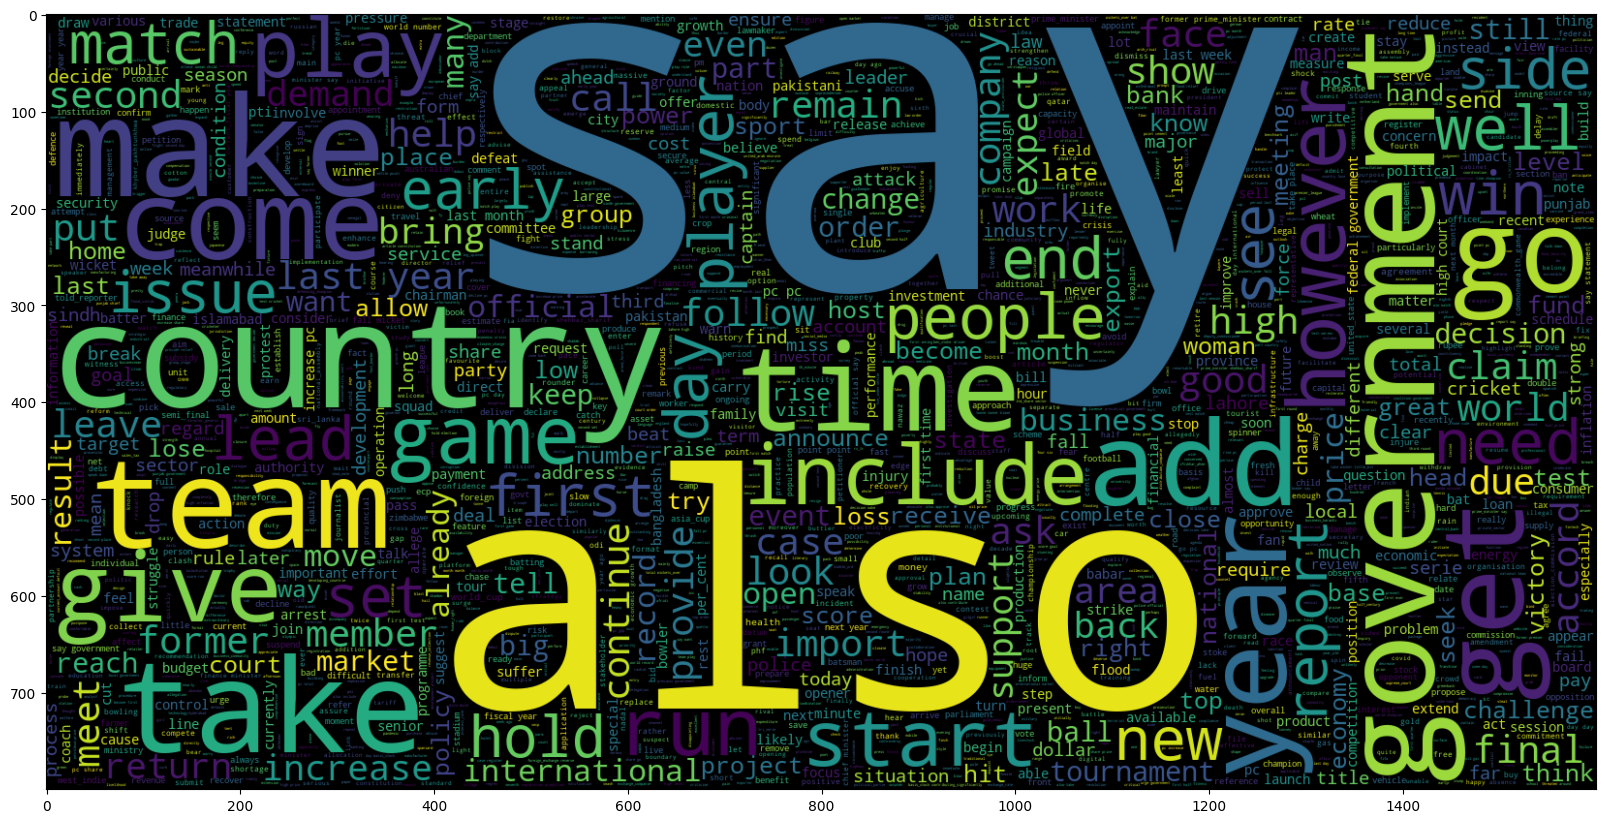

In [282]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df.clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [283]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 624
